# Evaluation

In this lab, we will explore different evaluation metrics in the context of some of the classifiers we have built in previous notebooks. One of the things we will quickly notice is that accuracy (the only metrics we've looked at so far) isn't always the best metric, particularly given class imbalance (as is the case with arrests, which we try to predict in the Chicago Crime Data).

In [1]:
# Import Pandas and Numpy
import numpy as np
import pandas as pd

# Import Plotting Libraries
import matplotlib.pyplot as plt
%matplotlib inline

## Load and Process the Chicago Crime Data

We'll load the data, drop the small number of rows that have undefined values in features we care about, and create a feature, 'Hour', corresponding to hour of the day.

In [2]:
df = pd.read_csv("../data/chicago-crimes-2019.csv.gz", compression='gzip')
print("Found {} NaN community area records.".format(df['Community Area'].isna().sum()))
df.dropna(inplace=True)
df['Hour'] = pd.to_datetime(df['Date']).dt.hour

Found 4 NaN community area records.


## Extract Features

Let's extract a few features that we want to work with.

In [3]:
df_backup = df.copy()
df = df.loc[:,['Hour', 'Community Area', 'Latitude', 'Longitude', 'Domestic', 'Arrest']]

labels = df.loc[:,'Hour':'Domestic'].columns.values
features = df.loc[:,'Hour':'Domestic'].values
target = df['Arrest'].values

## Random Forest Classifier

Random forest improves on a decision tree classifier using an ensemble learning method called bagging. In a random forest, 
1. many decision trees are trained. Each tree receives a boostrapped sample of observations, and 
2. each node only considers a subset of the features when determining the best split.

The `balanced` mode, which we use below, uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as 
n_samples / (n_classes * np.bincount(y)).

In [4]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, 
                            n_jobs=-1, 
                            n_estimators=100,
                            class_weight='balanced'
                           )
model = rf.fit(features,target)

### Evaluating the Random Forest Classifier

Because bagging performs training on resampled models with replacement, it effectively performs the equivalent of cross-validation. We'll do a cross validation just for kicks, but it's statistically equivalent to do a train-test split and measure accuracy that way.

In [5]:
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.80, 
                                                    random_state=5) # 80% training and 20% test

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

# prediction on test set
y_pred=rf.predict(X_test)

### Evaluation

Let's now evaluate our classifier.

#### Confusion Matrix

A confusion matric is a good way to understand errors of different types. We can see a lot of examples off diagonal, suggesting a fair number of incorrect answers.

[[148680  12775]
 [ 33042  11023]]


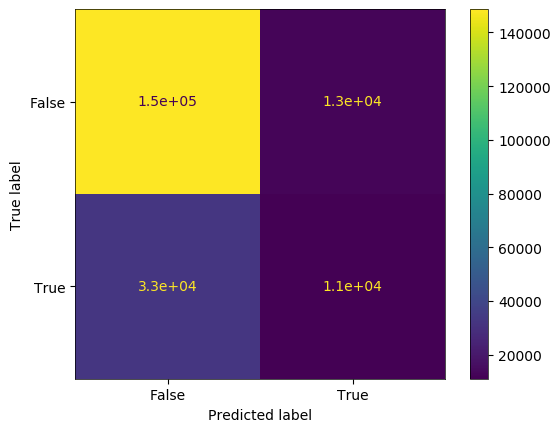

In [6]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve, plot_precision_recall_curve 

plot_confusion_matrix(rf,X_test,y_test)
print(metrics.confusion_matrix(y_test, y_pred))

#### Scoring

We can look at the following metrics:

* Accuracy: $\frac{TP + TN}{P + N}$ (total fraction of correct answers)


* Precision: $\frac{TP}{TP + FP}$ (fraction of positive detections that are correct)


* Recall (Detection Rate): $\frac{TP}{TP+FN}$ (fraction of positive classes correctly detected)


* F1 Score: $2 \cdot \frac{P\cdot R}{P + R}$

In [7]:
print("Accuracy:\t{}\nPrecision:\t{}\nRecall:\t\t{}\nF1 Score:\t{}\n".format(metrics.accuracy_score(y_test, y_pred),
                                                                           metrics.precision_score(y_test, y_pred),
                                                                           metrics.recall_score(y_test, y_pred),
                                                                           metrics.f1_score(y_test, y_pred)
                                                                          ))


Accuracy:	0.7770679252627481
Precision:	0.46319018404907975
Recall:		0.25015318279813914
F1 Score:	0.3248603804724224



In [8]:
print(metrics.classification_report(y_test, y_pred, target_names=['No Arrest', 'Arrest']))

              precision    recall  f1-score   support

   No Arrest       0.82      0.92      0.87    161455
      Arrest       0.46      0.25      0.32     44065

    accuracy                           0.78    205520
   macro avg       0.64      0.59      0.60    205520
weighted avg       0.74      0.78      0.75    205520



#### Receiver Operating Characteristic

The receiver operating characteristic (ROC) shows the recall (detection rate) against the false positive rate. Ideally one would have high detection rate and a low false positive rate. We have some work to do here, even just looking at the performance of the ROC curve.

Note that the ROC curve will always look the same, regardless of the probabilities of the underlying classes. It only looks at the relative accuracy with respect to each class (correct answers over the positive class vs. correct answers over the negative class).

For instances where (say) the positive class is rare, we may care about precision and recall.

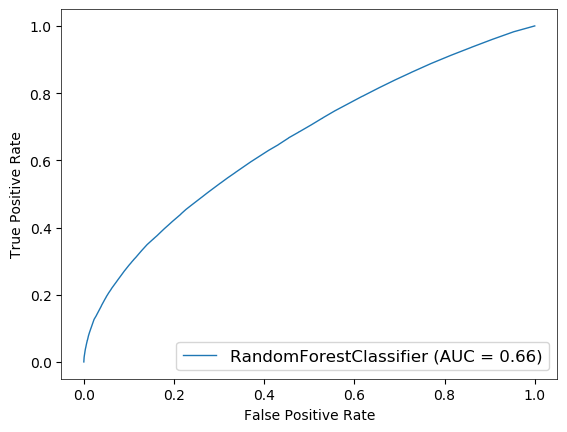

In [9]:
plot_roc_curve(rf,X_test,y_test)
plt.show()

#### Precision-Recall Curve

Precision recall curves tend to be useful to understand when the positive class (in this case, "Arrest") is more interesting than the negative class. In this case, we can see that as recall (detection rate) increases to anything useful, the precision drops off sharply (indicating that there will be a lot of positive predictions of arrest that are incorrect!).  

Here we see the importance of looking at precision-recall. When we have a positive class that is relatively rare, it can be particularly important to look at the PR curve.

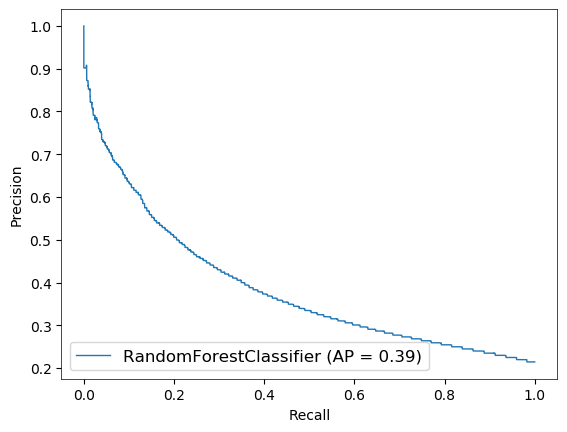

In [10]:
plot_precision_recall_curve(rf,X_test,y_test)
plt.show()

## Evaluation Function

Let's define an evaluation function that gives us metrics of interest. We can reuse this function, refine it in the future, etc., and see how these metrics look for other classifiers we have seen in previous lectures.

In [20]:
def runEval(clf,X_test,y_test,y_pred,target_names=None):
    plot_confusion_matrix(clf,X_test,y_test)
    print(metrics.confusion_matrix(y_test, y_pred))
    print("Accuracy:\t{}\nPrecision:\t{}\nRecall:\t\t{}\nF1 Score:\t{}\n".format(metrics.accuracy_score(y_test, y_pred),
                                                                           metrics.precision_score(y_test, y_pred),
                                                                           metrics.recall_score(y_test, y_pred),
                                                                           metrics.f1_score(y_test, y_pred)
                                                                          ))
    plot_roc_curve(clf,X_test,y_test)
    plot_precision_recall_curve(clf,X_test,y_test)

## Evaluating Other Models

### Logistic Regression

In [43]:
df = df_backup

# Convert Arrest to int type
df['Arrest'] = df['Arrest'].astype(int)

# Number of Arrests per hour
arrest_hour = pd.DataFrame(df.groupby(['Hour'])['Arrest'] \
                                              .sum() \
                                              .reset_index(name='arrests') \
                                              .sort_values(['Hour'], ascending=True))

# Number of Incidents per hour
all_hour = pd.DataFrame(df.groupby(['Hour'])['ID'] \
                                              .count() \
                                              .reset_index(name='incidents') \
                                              .sort_values(['Hour'], ascending=True))

# New Dataframe
adf = pd.merge(arrest_hour,all_hour,on=['Hour'])
adf['prob'] = adf['arrests'] / adf['incidents']

# This is a derived binary variable that is "toy" for the sake of illustration.
adf['pthresh'] = adf['prob'] > 0.18
adf['hrs'] = (adf['Hour'] + 21) % 24

adf.head(5)

,Hour,arrests,incidents,prob,pthresh,hrs
0,0,2263,12335,0.183462,True,21
1,1,1768,7904,0.223684,True,22
2,2,1339,6891,0.194311,True,23
3,3,974,5457,0.178486,False,0
4,4,659,4391,0.150080,False,1


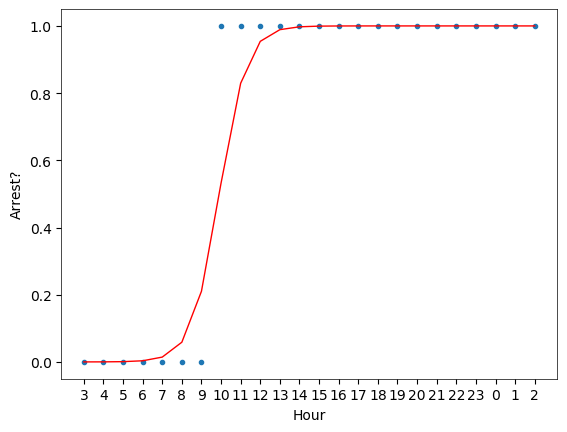

In [48]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

# Features for fitting the model.
x = adf['hrs'].astype('float').values.reshape(-1,1)
y = adf['pthresh']
z = np.arange(0.,24.,1).reshape(-1, 1);

penalty='l2'
C = 20
solver='lbfgs'

pipelineCV = Pipeline([
    ('norm', StandardScaler()),
    ('logr', LogisticRegressionCV(penalty=penalty,
                                  class_weight='balanced',
                                  Cs=C,
                                  cv=2,
                                  random_state=0,
                                  solver=solver)),
])


pipelineCV.fit(x,y)
lineCV = pipelineCV.predict_proba(z)[:,1]

hours = adf['Hour'][3:].append(adf['Hour'][0:3])
plt.xticks(np.arange(24),hours)
plt.xlabel('Hour')
plt.ylabel('Arrest?')
plt.plot(x,y,'.')
plt.plot(z, lineCV, color='red')
plt.show()

[[ 5  0]
 [ 0 15]]
Accuracy:	1.0
Precision:	1.0
Recall:		1.0
F1 Score:	1.0



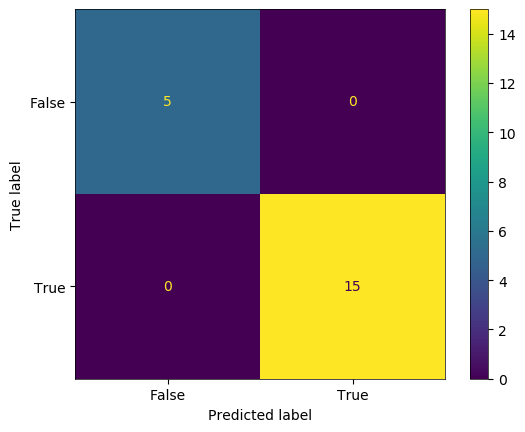

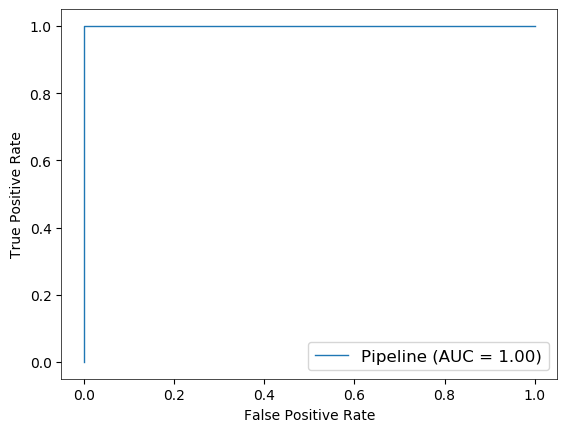

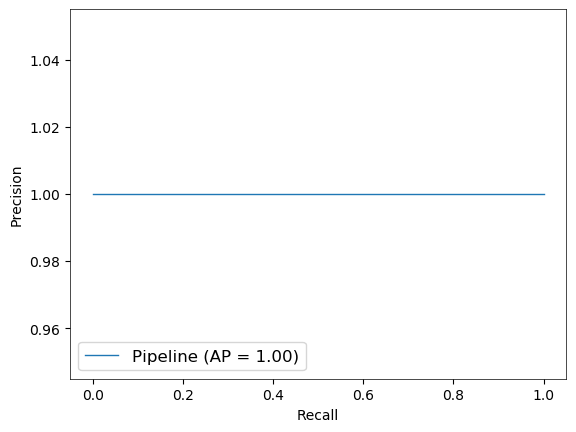

In [49]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.80, 
                                                    random_state=5) # 80% training and 20% test

pipelineCV.fit(X_train,y_train)
y_pred = pipelineCV.predict(X_test)
runEval(pipelineCV,X_test,y_test,y_pred,['No Arrest','Arrest'])

### Support Vector Machines

In [12]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.pipeline import Pipeline

df = df_backup
features = df.loc[:,['Primary Type', 'Domestic', 'Community Area','Location Description','Hour']]
features2d = df.loc[:,['Community Area', 'Hour']]

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(features2d, 
                                                    target, 
                                                    test_size=0.80, 
                                                    random_state=5) # 80% training and 20% test

In [13]:
svc = Pipeline([
    ('ohe', OneHotEncoder()),
    ('svc', SVC(kernel='linear', random_state=0, gamma=0.5, C=1.0, class_weight='balanced')),
])

In [14]:
# Train the model using the training sets y_pred=clf.predict(X_test)
svc.fit(X_train,y_train)

# prediction on test set
y_pred = svc.predict(X_test)

[[98036 63419]
 [19122 24943]]
Accuracy:	0.5983797197353056
Precision:	0.2822819764152011
Recall:		0.5660501531827982
F1 Score:	0.3767056567014279



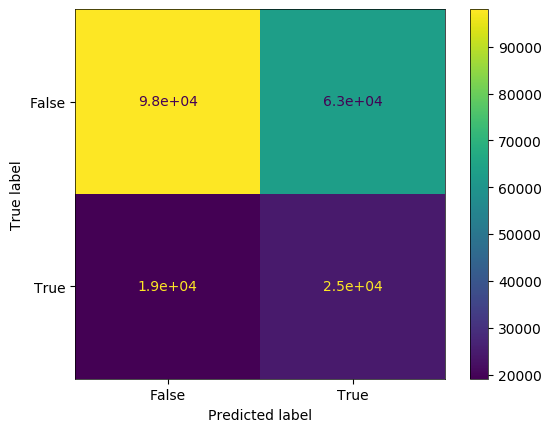

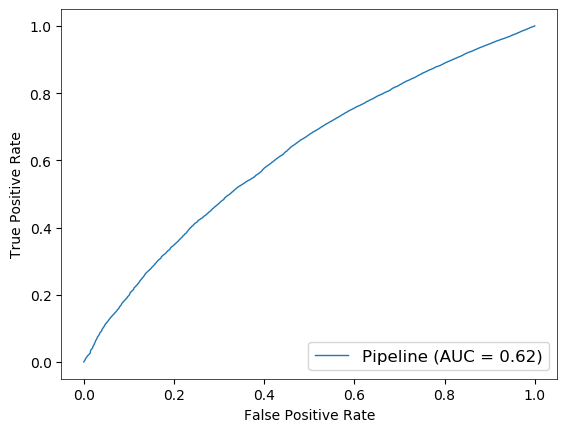

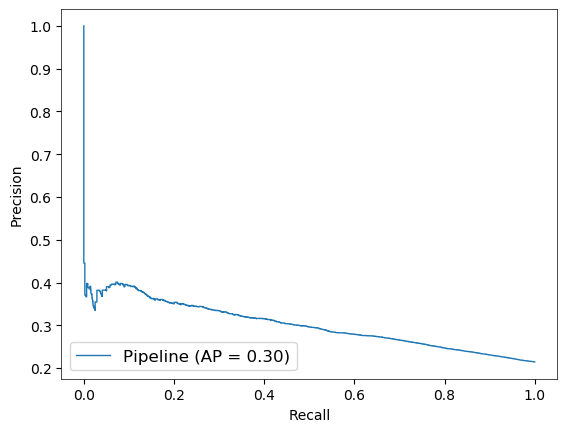

In [21]:
runEval(svc,X_test,y_test,y_pred,['No Arrest','Arrest'])